In [1]:
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
from scipy.stats import randint
from sklearn.model_selection import cross_val_score, cross_val_predict, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder
from src.features.build_features import MostFrequentImputer, load_data, add_bucket, set_title

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import numpy as np
# To plot pretty figures
%matplotlib inline
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Load Data 

In [42]:
# train data 
train_data = load_data("train.csv")
y_train = train_data["Survived"]

# test data
test_data = load_data("test.csv")

# Transform data

## Add new columns

In [43]:
relatives = ['SibSp' ,'Parch']

def add_columns(df):
    df['family'] = df[relatives].sum(axis=1)
    df['traveling_alone'] = np.where(df['family']==0,1,0)
    df['Sex'] = np.where(df['Sex']=='female',0,1)
    df['Age_Bucket'] = add_bucket(df['Age'], bins=6)
    df['Fare_Bucket'] = add_bucket(df['Fare'], bins=6)
    df['Title'] = df['Name'].apply(set_title)
    df['name_length'] = df['Name'].apply(len)
    df['Cabin'] = df['Cabin'].apply(lambda x: 0 if type(x) == float else 1)
    return df


train_data = add_columns(train_data)
test_data = add_columns(test_data)

Sex works better as category than converting to 0 and 1 

In [44]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,family,traveling_alone,Age_Bucket,Fare_Bucket,Title,name_length
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,0,S,1,0,1.0,0,Mr,23
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,1,C,1,0,4.0,5,Mrs,51
2,3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,0,S,0,1,2.0,1,Miss,22
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,1,S,1,0,4.0,5,Mrs,44
4,5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,0,S,0,1,4.0,1,Mr,24


## Pipelines

In [45]:
# numerical pipeline
num_pipeline = Pipeline([ ("imputer", SimpleImputer(strategy="median")) ])

In [46]:
# categorical pipeline 
cat_pipeline = Pipeline([
        ("imputer", MostFrequentImputer()),
        ("cat_encoder", OneHotEncoder(sparse=False)),
    ])

In [47]:
# Full pipeline 
cat_attribs = ["Pclass", 'Embarked',  'Age_Bucket', 'Fare_Bucket', 'Title',]
num_attribs = [ "family", 'name_length',  'traveling_alone', 'Cabin', 'Sex', 'Age', 'Fare']

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", cat_pipeline, cat_attribs),
    ])

X_train = full_pipeline.fit_transform(train_data)
X_test = full_pipeline.transform(test_data)

# Find groupings with PCA and GMM 
Selected a few features to find a grouping. Forced PCA to separate data into two groups. Used GMM to predict the grouping. 

In [48]:
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture

In [49]:
X_train
X2 = PCA(2, svd_solver='full').fit_transform(X_train)

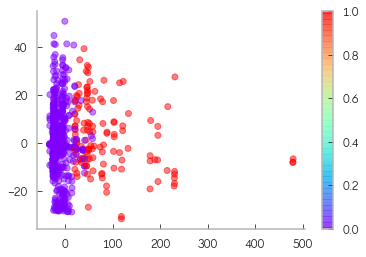

In [50]:
gmm = GaussianMixture(2)
gmm.fit(X_train)
labels = gmm.predict(X_train)
plt.scatter(X2[:, 0], X2[:, 1], c = labels, cmap='rainbow', alpha=.5);
plt.colorbar();

In [51]:
# add grouping to labels to 
X_train = np.c_[X_train, gmm.predict(X_train)]
X_test = np.c_[X_test, gmm.predict(X_test)]


# Test models

In [52]:
from sklearn.neighbors import KNeighborsClassifier
knn_clf = KNeighborsClassifier(n_jobs=-1, weights='distance', n_neighbors=4)

In [53]:
from sklearn.svm import SVC
svm_clf = SVC(gamma="auto")

In [54]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)

In [55]:
from sklearn.linear_model import LogisticRegression
log_clf = LogisticRegression(random_state=42, solver= 'liblinear' , penalty='l2')

In [56]:
ada_clf = AdaBoostClassifier()

In [57]:
xgb_clf = GradientBoostingClassifier(random_state=42)

In [58]:
models = [knn_clf, svm_clf,  log_clf, ada_clf, forest_clf, xgb_clf]
# train models
scores = []
for model in models:
    scores.append(cross_val_score(model, X_train, y_train, cv=10))

In [59]:
labels = ['KNN', 'SVM', 'Log Reg', 'Ada Boost', "Random Forest", 'Gradient Boosting']
mean_scores = [score.mean() for score in scores]
pd.DataFrame({'models': labels, 'scores':mean_scores}).set_index('models')

,scores
models,
KNN,0.716212
SVM,0.734177
Log Reg,0.814827
Ada Boost,0.806986
Random Forest,0.813729
Gradient Boosting,0.817061


## Plot the Classifiers scores 

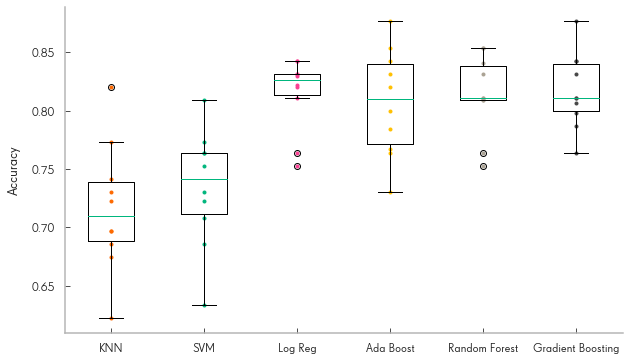

In [60]:
plt.figure(figsize=(10, 6))

# create scatter points 
for i, score in enumerate( scores, start=1): 
    plt.plot([i]*10, score, ".")

plt.boxplot(scores, labels=labels)
plt.ylabel("Accuracy", fontsize=14)
#plt.xlim(-.5,5.5)
#plt.ylim(.5,1)
plt.show()

# Tune xgboost  model 

In [61]:
param_distribs = {
        'n_estimators': randint(low=1, high=500),
        'max_features': randint(low=1, high=10),
    }

rnd_search = RandomizedSearchCV(xgb_clf , param_distributions=param_distribs,
                                n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42)
rnd_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_sampl...      subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=10, n_jobs=None,
          param_distributions={'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1a1f53d2e8>, 'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1a1f53d6d8>},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring='neg_mean_squared_error',
          verbose=0)

In [62]:
# rename classifier 
xgb_clf = rnd_search.best_estimator_

## inspect hyperparameters

In [63]:
cvres = rnd_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print('score: \t {}  \t \t {}'.format(round(np.sqrt(-mean_score),4 ) , params))


score: 	 0.4117  	 	 {'n_estimators': 436, 'max_features': 7}
score: 	 0.413  	 	 {'n_estimators': 189, 'max_features': 8}
score: 	 0.4211  	 	 {'n_estimators': 103, 'max_features': 5}
score: 	 0.4171  	 	 {'n_estimators': 215, 'max_features': 3}
score: 	 0.4144  	 	 {'n_estimators': 373, 'max_features': 8}
score: 	 0.4103  	 	 {'n_estimators': 360, 'max_features': 4}
score: 	 0.4184  	 	 {'n_estimators': 131, 'max_features': 8}
score: 	 0.4103  	 	 {'n_estimators': 309, 'max_features': 6}
score: 	 0.4089  	 	 {'n_estimators': 344, 'max_features': 2}
score: 	 0.4089  	 	 {'n_estimators': 386, 'max_features': 6}


In [64]:
# retrieve categorical attribute names 
cat_attribs_encoded= list(full_pipeline.transformers_[1][1].named_steps["cat_encoder"].get_feature_names())
cat_attribs_encoded

['x0_1',
 'x0_2',
 'x0_3',
 'x1_C',
 'x1_Q',
 'x1_S',
 'x2_0.0',
 'x2_1.0',
 'x2_2.0',
 'x2_3.0',
 'x2_4.0',
 'x2_5.0',
 'x3_0',
 'x3_1',
 'x3_2',
 'x3_3',
 'x3_4',
 'x3_5',
 'x4_Miss',
 'x4_Mr',
 'x4_Mrs',
 'x4_Prestige']

In [65]:
feature_importances = rnd_search.best_estimator_.feature_importances_
feature_importances

array([0.06131472, 0.06027542, 0.01834058, 0.02644524, 0.13550393,
       0.06498993, 0.08881172, 0.00423403, 0.01287111, 0.07321719,
       0.01525947, 0.0102695 , 0.00645654, 0.00710338, 0.00392898,
       0.00770198, 0.00424881, 0.00541903, 0.0066341 , 0.00914849,
       0.00922436, 0.00265083, 0.00658383, 0.00749069, 0.03115881,
       0.11396875, 0.06886336, 0.08512257, 0.018299  , 0.03446364])

In [66]:
trained_columns = num_attribs + cat_attribs_encoded + ['group']
sorted(zip(feature_importances,trained_columns), reverse=True)

[(0.13550392964501565, 'Sex'),
 (0.11396875265789688, 'x4_Miss'),
 (0.08881171978049739, 'Fare'),
 (0.08512257047424245, 'x4_Mrs'),
 (0.07321719170737499, 'x0_3'),
 (0.06886336054541865, 'x4_Mr'),
 (0.06498992500141162, 'Age'),
 (0.06131472341154673, 'family'),
 (0.06027542138630429, 'name_length'),
 (0.03446364126268327, 'group'),
 (0.031158813627786, 'x3_5'),
 (0.026445238577250185, 'Cabin'),
 (0.018340583383965065, 'traveling_alone'),
 (0.018298996377476784, 'x4_Prestige'),
 (0.015259472929268731, 'x1_C'),
 (0.012871114462036861, 'x0_2'),
 (0.01026949770113223, 'x1_Q'),
 (0.009224362629872309, 'x3_1'),
 (0.009148485080106808, 'x3_0'),
 (0.007701981698773832, 'x2_2.0'),
 (0.007490687358454284, 'x3_4'),
 (0.007103376518105478, 'x2_0.0'),
 (0.006634103594080757, 'x2_5.0'),
 (0.006583830557068744, 'x3_3'),
 (0.006456538723106253, 'x1_S'),
 (0.005419032417291374, 'x2_4.0'),
 (0.004248807158462436, 'x2_3.0'),
 (0.004234032024159355, 'x0_1'),
 (0.003928977798330979, 'x2_1.0'),
 (0.00265083

In [67]:
xgb_clf.score(X_train, y_train)

0.9147025813692481

In [68]:
xgb_params = xgb_clf.get_params()

## Model metrics

### ROC curve 

In [69]:
y_probas=xgb_clf.predict_proba(X_train)
y_scores = y_probas[:, 1] # score = proba of positive class

In [70]:
fpr, tpr, thresholds = roc_curve(y_train, y_scores)

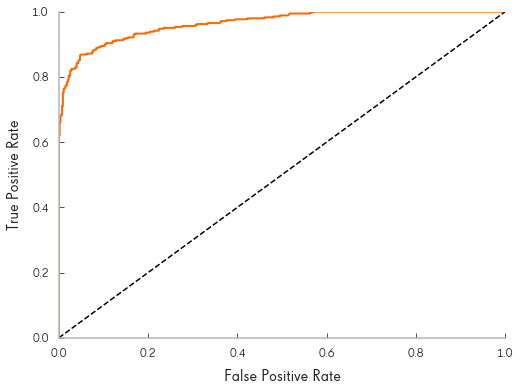

In [71]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)

plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr)
plt.show()



In [78]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train, y_scores)

0.9643051161601636

In [79]:
y_train_pred = xgb_clf.predict(X_train)
precision_score(y_train, y_train_pred)

0.9182389937106918

In [80]:
recall_score(y_train, y_train_pred)

0.8538011695906432

In [81]:
# f1 score 
f1_score(y_train, y_train_pred)

0.8848484848484848

### Precision recall curve

In [82]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train, y_scores)

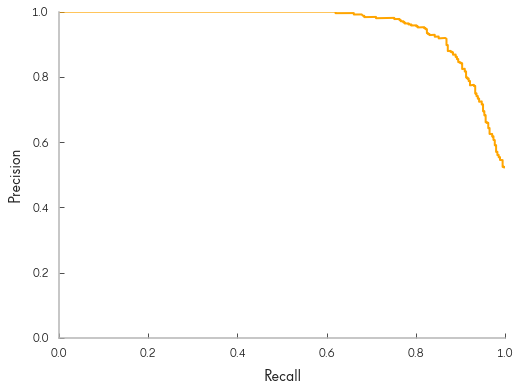

0.8641043257810587

In [105]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "orange", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.show()
roc_auc_score(y_train, y_scores)

# Tune Log Reg model

In [99]:
# Create hyperparameter options
hyperparameters ={'penalty': ['l2', 'l1'], 
                         'class_weight': [None, 'balanced'],
                         'C': np.logspace(-20, 20, 10000), 
                         'intercept_scaling': np.logspace(-20, 20, 10000)}
# Create randomized search 5-fold cross validation and 100 iterations
clf = RandomizedSearchCV(log_clf, hyperparameters, random_state=1, n_iter=100, cv=5, verbose=0, n_jobs=-1)
# Fit randomized search
log_model = clf.fit(X_train, y_train)

/Users/cristian/miniconda3/envs/mlbook/lib/python3.5/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [100]:
# View best hyperparameters
print('Best Penalty:', log_model.best_estimator_.get_params()['penalty'])
print('Best C:', log_model.best_estimator_.get_params()['C'])

Best Penalty: l1
Best C: 0.05418429004299554


In [101]:
log_model.score(X_train, y_train)

0.8125701459034792

In [102]:
y_probas=log_model.predict_proba(X_train)
y_scores = y_probas[:, 1] # score = proba of positive class

In [103]:
fpr, tpr, thresholds = roc_curve(y_train, y_scores)

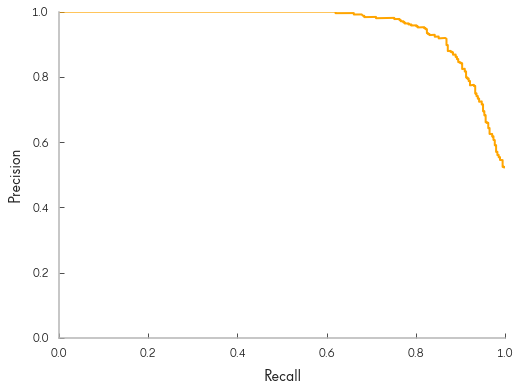

In [104]:
plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.show()

# Create prediction file 

In [84]:

test_data['Survived'] = xgb_clf.predict(X_test)
submission = test_data[['PassengerId', 'Survived']]
# save
submission.to_csv(path_or_buf = 'data/processed/submissions.csv', index=False)

# Results 

**xgboost**
- kaggle score: 0.75119
- score: 0.8619528619528619
- auc: 0.9257368527572727
- cat_attribs = ["Pclass", 'Embarked',  'Age_Bucket', 'Fare_Bucket', 'Title', 'Sex', 'traveling_alone', 'Cabin']
- num_attribs = [ "family", 'name_length']

**xgboost with cv=10**
- kaggle score:0.75598
- score: 0.8855218855218855
- auc: 0.9409878673611777
- cat_attribs = ["Pclass", 'Embarked',  'Age_Bucket', 'Fare_Bucket', 'Title', 'Sex', 'traveling_alone', 'Cabin']
- num_attribs = [ "family", 'name_length']

**xgboost**
- kaggle score 0.74641
- score: 0.8810325476992144
- auc: 0.9438612469242323
- cat_attribs = ["Pclass", 'Embarked',  'Age_Bucket', 'Fare_Bucket', 'Title', 'Sex', 'traveling_alone', 'Cabin']
- num_attribs = [ "family", 'name_length']


**xgboost**
- kaggle score 0.75598
- score: 0.9147025813692481
- auc: 0.9643051161601636
- cat_attribs = ["Pclass", 'Embarked',  'Age_Bucket', 'Fare_Bucket', 'Title',]
- num_attribs = [ "family", 'name_length',  'traveling_alone', 'Cabin', 'Sex', 'Age', 'Fare']